In [1]:
%pylab inline

import pickle
import scipy.stats as stats
import scipy.optimize as opt
import pandas as pd
import deribit_api as api
import strategy as strat

tableau = pickle.load(open('tableau.colors', 'rb'))
rcParams['axes.prop_cycle'] = cycler('color',tableau)
rcParams["axes.grid"] = True
rcParams["lines.linewidth"] = 2.5
rcParams["figure.figsize"] = (10,7)

Populating the interactive namespace from numpy and matplotlib


In [1527]:
import vol
from imp import reload
reload(vol)
from vol import *

In [4]:
keys = open('keys.txt', 'r').read().split('\n')[:-1]
client = api.RestClient(keys[0], keys[1])

In [1524]:
instruments = client.getinstruments()

In [27]:
my_surface = load_surface('2017-12-30')

In [1812]:
# Pull OTM option prices 
expiry = '26JAN18'
options = [inst for inst in instruments if inst['kind'] == 'option' and expiry_codes[inst['expiration']] == expiry]
S = client.index()['btc']
OTM = [opt for opt in options if (opt['optionType'] == 'call' and opt['strike'] > S) or \
                                 (opt['optionType'] == 'put' and opt['strike'] <= S)]
for i in range(len(OTM)):
    book = client.getorderbook(OTM[i]['instrumentName'])
    bid = book['bids'][0]['price'] if len(book['bids']) > 0 else 0
    ask = book['asks'][0]['price'] if len(book['asks']) > 0 else 0
    OTM[i]['bid'] = bid
    OTM[i]['ask'] = ask
OTM = sorted(OTM, key=lambda x: x['strike'])
T = time_to_expiry(convert_GMT_EST(OTM[0]['expiration']), convert_GMT_EST(book['tstamp']*1e6))

In [1813]:
# Solve for bid and ask vols
r = 0.10; c = 0.00 # forward params
bid_vols = np.zeros(len(OTM))
ask_vols = np.zeros(len(OTM))
for i in range(len(OTM)):
    K = OTM[i]['strike']
    is_call = (OTM[i]['instrumentName'][-1] == 'C')
    bid_vols[i] = BSvol(S, K, T, r, c, S*OTM[i]['bid'], call=is_call) if OTM[i]['bid'] != 0 else 0
    ask_vols[i] = BSvol(S, K, T, r, c, S*OTM[i]['ask'], call=is_call) if OTM[i]['ask'] != 0 else 0

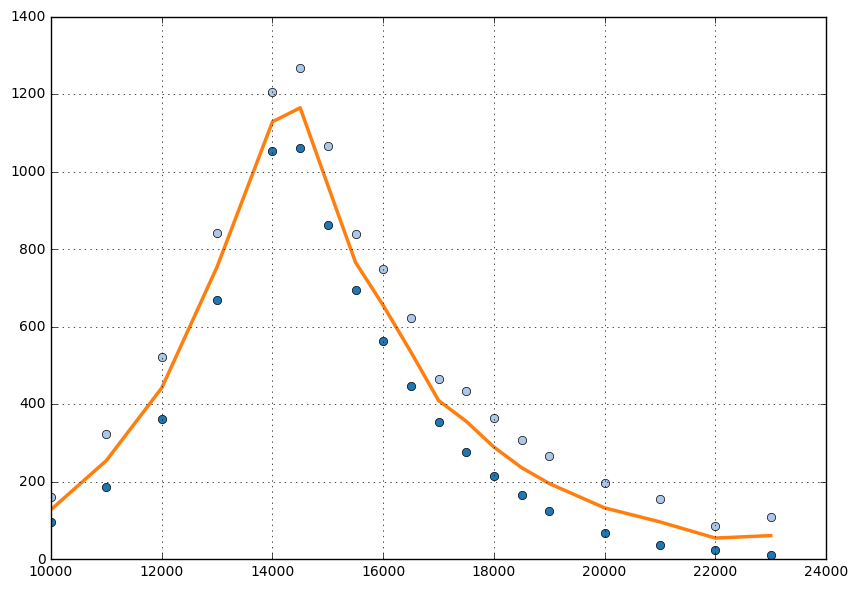

In [1814]:
# Plot prices
bids = np.array([S*opt['bid'] for opt in OTM])
asks = np.array([S*opt['ask'] for opt in OTM])
strikes = np.array([opt['strike'] for opt in OTM])

clean_bids = [i for i in range(len(bids)) if bids[i] != 0]
clean_asks = [i for i in range(len(asks)) if asks[i] != 0]
clean_mids = [i for i in range(len(asks)) if i in clean_bids and i in clean_asks]

plot(strikes[clean_bids], bids[clean_bids], 'o')
plot(strikes[clean_asks], asks[clean_asks], 'o')
plot(strikes[clean_mids], 0.5*(bids[clean_mids]+asks[clean_mids]))

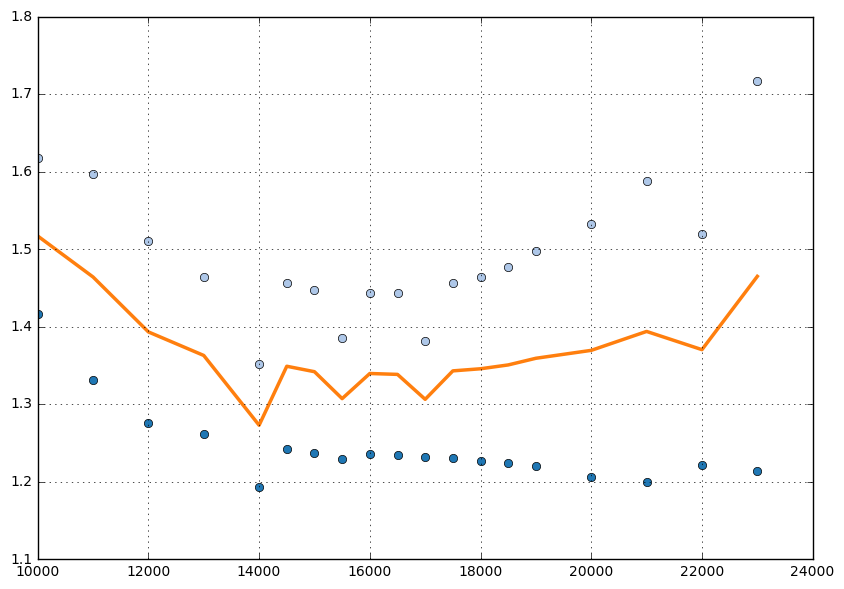

In [1815]:
# Plot vols
plot(strikes[clean_bids], bid_vols[clean_bids], 'o')
plot(strikes[clean_asks], ask_vols[clean_asks], 'o')
plot(strikes[clean_mids], 0.5*(bid_vols[clean_mids]+ask_vols[clean_mids]))

In [1816]:
# Fit surface
log_strikes = np.log(strikes/S)
p = opt.curve_fit(Sigma_explicit, log_strikes[clean_mids], 0.5*(bid_vols[clean_mids]+ask_vols[clean_mids]))[0]
p

array([ 1.33592394,  0.2168975 ,  0.90206519])

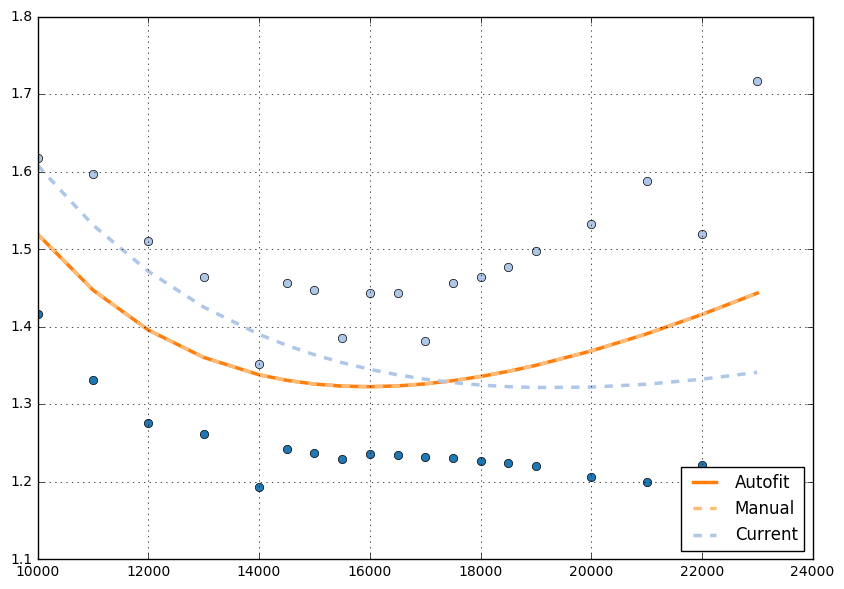

In [1817]:
# Plot surface, show tweaks
pATM_shift  = 0.00
pSKEW_shift = 0.00
pVoV_shift  = 0.00

x = strikes

plot(x[clean_bids], bid_vols[clean_bids], 'o')
plot(x[clean_asks], ask_vols[clean_asks], 'o')

# Autofit
plot(x, Sigma_explicit(log_strikes,p[0],p[1],p[2]), label='Autofit')

# Modified autofit
plot(x, Sigma_explicit(log_strikes,p[0]+pATM_shift,p[1]+pSKEW_shift,p[2]+pVoV_shift), '--', label='Manual')

# Existing surface
plot(x, Sigma(log_strikes,my_surface[expiry_codes[OTM[0]['expiration']]]), '--', color=tableau[1], label='Current')

legend(loc='lower right')

In [1818]:
# Save my surface
my_surface_slice = [p[0]+pATM_shift, p[1]+pSKEW_shift, p[2]+pVoV_shift]
my_surface[expiry] = my_surface_slice
save_surface(my_surface)
my_surface

{'12JAN18': [1.7619445724108984, 1.2347020499730199, 16.808921790696431],
 '19JAN18': [1.3455591735176782, 0.33529892751642865, 1.209448195233098],
 '26JAN18': [1.3359239359448751, 0.21689749935639185, 0.90206519115317707],
 '30MAR18': [1.3141606559579386, 0.098909921582285509, 0.13013037581140885],
 '5JAN18': [1.426604687452357, -1.1385516276036438, 66.405863893129194]}

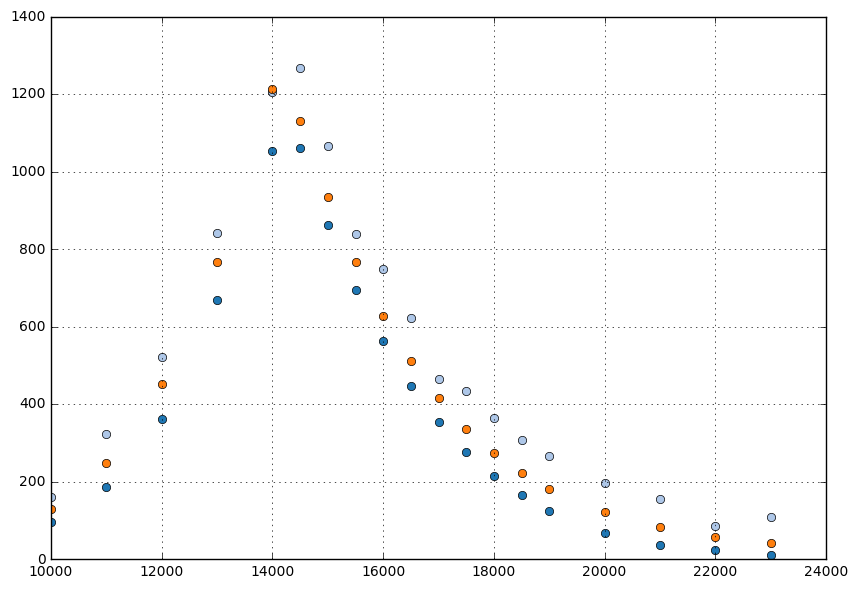

In [1819]:
my_prices = np.zeros(len(strikes))
for i in range(len(strikes)):
    sigma = Sigma(np.log(strikes[i]/S), my_surface_slice)
    if strikes[i] <= S:
        my_prices[i] = BSput(S, strikes[i], T, sigma, 0.0, 0.0)
    else:
        my_prices[i] = BScall(S, strikes[i], T, sigma, 0.0, 0.0)

plot(strikes[clean_bids], bids[clean_bids], 'o')
plot(strikes[clean_asks], asks[clean_asks], 'o')
plot(strikes, my_prices, 'o')

In [1820]:
t = time_to_expiry(convert_GMT_EST(OTM[0]['expiration']), now_EST())
index  = client.index()['btc']
strike = 17000
sigma  = Sigma(np.log(strike/index), my_surface[expiry_codes[OTM[0]['expiration']]])
BScall(index, strike, t, sigma, 0.0, 0.0)

415.35104810205848

In [1843]:
S = client.index()['btc']
S

13879.16

In [1844]:
portfolio = {'BTC-30MAR18-20000-C': -1.00,
             'BTC-30MAR18-17000-C':  1.00,
             'BTC-30MAR18-35000-C': -1.00,
             'BTC-30MAR18-7000-P':   1.50,
             'BTC-30MAR18-9500-P':  -0.70,
             'BTC-26JAN18-0.01-C':   0.00,
             'BTC-26JAN18-13000-C':  0.10,
             'BTC-30MAR18-30000-C': -0.90,
             'BTC-30MAR18-8500-P':   0.40,
             'BTC-26JAN18-20000-C': -0.70,
             'BTC-19JAN18-16500-C': -0.10,
             'BTC-19JAN18-15500-C': -0.10,
             'BTC-19JAN18-12000-P': -0.80,
             'BTC-19JAN18-11000-P': -1.00}
options = list(portfolio.keys())

In [1845]:
quantities = np.array(list(portfolio.values()))
overrides = {'spot': S, 'vol_shift': 0.0, 'time_shift': -0/365}
values = np.array([PV(opt, my_surface, overrides) for opt in options])
deltas = np.array([delta(opt, my_surface, overrides) for opt in options])
gammas = np.array([gamma(opt, my_surface, overrides) for opt in options])
vegas = np.array([vega(opt, my_surface, overrides) for opt in options])
thetas = np.array([theta(opt, my_surface, overrides) for opt in options])

In [1846]:
df = pd.DataFrame(columns=['Px','Q','PV','Delta','Gamma','Vega','Theta'])
for idx in range(len(options)):
    instrument = options[idx]
    row = pd.Series()
    row['Expiry'] = instrument.split('-')[1]
    row['PutCall'] = 'call' if instrument.split('-')[3] == 'C' else 'put'
    row['Strike'] = float(instrument.split('-')[2])
    row['Px'] = round(values[idx],2)
    row['Q']  = quantities[idx]
    row['PV']    = values[idx]*row['Q']
    row['Delta'] = deltas[idx]*row['Q']
    row['Gamma'] = gammas[idx]*row['Q']
    row['Vega']  = vegas[idx]*row['Q']
    row['Theta'] = thetas[idx]*row['Q']
    row.name = instrument
    df = df.append(row)
total = df.sum()
total.name = 'total'
total['Expiry'] = ''
total['PutCall'] = ''
total['Strike'] = ''
total['Px'] = S
df = df.append(total)[['Expiry','Strike','PutCall','PV','Q','Delta','Gamma','Vega','Theta','Px']]
df = df.sort_values(['Expiry','Strike'])

In [1847]:
def color_negpos(val):
    color = 'red' if val < 0 else 'blue'
    return 'color: %s' % color
df.style.\
    applymap(color_negpos,subset=['PV','Q','Delta','Gamma','Vega','Theta']).\
    format({'PV': '{:>.2f}', 'Delta': '{:>.2f}', 'Gamma': '{:>.2f}', 'Vega': '{:>.2f}', 'Theta': '{:>.2f}',
                 'Q': '{:>.1f}', 'Px': '{:>,.2f}'})

,Expiry,Strike,PutCall,PV,Q,Delta,Gamma,Vega,Theta,Px
total,,,,-188.17,-3.3,255.00,-347.47,-44.98,107.62,"13,879.16"
BTC-19JAN18-11000-P,19JAN18,11000,put,-43.24,-1.0,548.92,-68.30,-2.74,25.19,43.24
BTC-19JAN18-12000-P,19JAN18,12000,put,-110.77,-0.8,1318.16,-140.33,-4.70,46.47,138.46
BTC-19JAN18-15500-C,19JAN18,15500,call,-21.03,-0.1,-303.55,-35.65,-0.80,7.63,210.25
BTC-19JAN18-16500-C,19JAN18,16500,call,-8.43,-0.1,-141.34,-20.75,-0.49,4.27,84.32
BTC-26JAN18-0.01-C,26JAN18,0.01,call,0.00,0.0,0.00,0.00,0.00,0.00,"13,879.16"
BTC-26JAN18-13000-C,26JAN18,13000,call,171.92,0.1,938.48,32.46,1.74,-5.71,"1,719.25"
BTC-26JAN18-20000-C,26JAN18,20000,call,-68.99,-0.7,-618.96,-55.84,-4.64,14.61,98.56
BTC-30MAR18-7000-P,30MAR18,7000,put,531.56,1.5,-1191.65,29.15,26.16,-11.79,354.37
BTC-30MAR18-8500-P,30MAR18,8500,put,267.11,0.4,-604.20,13.00,10.38,-4.53,667.77


In [1848]:
spots = (np.arange(151)-75)*50+S
t = time_to_expiry(pd.to_datetime('2018-01-04').tz_localize('EST'), now_EST())
values = [(quantities*np.array([PV(opt, my_surface, overrides={'spot': s, 'time_shift': -1/365}) 
          for opt in portfolio])).sum() for s in spots]
#deltas = [(quantities*np.array([delta(opt, my_surface, overrides={'spot': s, 'time_shift': -1/365}) 
#          for opt in portfolio])).sum() for s in spots]

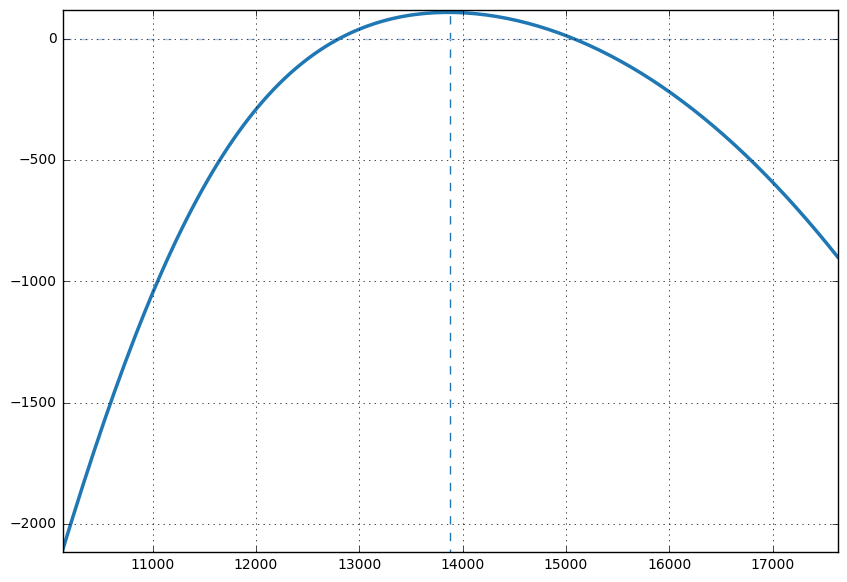

In [1849]:
hedge = 0.00
pnl = values-df.loc['total'].PV + hedge*(spots-S)
plot([S,S], [np.min(pnl)-100, np.max(pnl)+100], '--', lw=1)
plot([spots[0],spots[-1]],[0.0,0.0], '--', lw=1)
plot(spots, pnl, color=tableau[0])
ylim(np.min(pnl)-10,np.max(pnl)+10)
xlim(spots[0],spots[-1]);

In [1850]:
option = 'BTC-19JAN18-11000-P'; Q = 1.00
overrides = {'spot': client.index()['btc'], 'vol_shift': 0.0}
series = pd.Series()
series['Px'] = PV(option, my_surface, overrides)
series['Delta'] = delta(option, my_surface, overrides)
series['Gamma'] = gamma(option, my_surface, overrides)
series['Vega'] = vega(option, my_surface, overrides)
series['Theta'] = theta(option, my_surface, overrides)
series['Mid Vol'] = Sigma(np.log(float(option.split('-')[2])/S), my_surface[option.split('-')[1]])
series['Vol'] = series['Mid Vol'] + overrides['vol_shift']
series['Spot'] = overrides['spot']
series.name = option
o = pd.DataFrame()
o = Q*o.append(series)[['Px', 'Spot', 'Vol', 'Mid Vol', 'Delta', 'Gamma', 'Vega', 'Theta']]
o.style.\
    applymap(color_negpos,subset=['PV','Q','Delta','Gamma','Vega','Theta']).\
    format({'Delta': '{:>.2f}', 'Gamma': '{:>.2f}', 'Vega': '{:>.2f}', 'Theta': '{:>.2f}',
            'Mid Vol': '{:>.2%}', 'Vol': '{:>.2%}', 'Spot': '{:>,.2f}'})

,Px,Spot,Vol,Mid Vol,Delta,Gamma,Vega,Theta
BTC-19JAN18-11000-P,43.1749,"13,880.76",148.89%,148.89%,-548.12,68.21,2.74,-25.16
